In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

%matplotlib inline

## 1/Using geopandas

### 1/ I need a shape:

In [3]:
tn_shape = gpd.read_file('../data/tn_shape/tl_2016_47_cousub.shp')
tn_shape.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,053,90054,02464232,4705390054,1,District 1,28,Z1,G4040,None,None,None,N,96264311,137578,+35.8364702,-088.7717523,"POLYGON ((-88.84931 35.84546, -88.84925 35.846..."
1,47,053,91764,02464308,4705391764,10,District 10,28,Z1,G4040,None,None,None,N,10508081,0,+35.9588678,-088.9411265,"POLYGON ((-88.95553 35.96024, -88.95544 35.960..."
2,47,053,91954,02464338,4705391954,11,District 11,28,Z1,G4040,None,None,None,N,217597201,1369276,+35.9897003,-088.7783091,"POLYGON ((-88.89445 35.95602, -88.89384 35.956..."
3,47,053,92144,02464357,4705392144,12,District 12,28,Z1,G4040,None,None,None,N,31322917,7879,+35.8879687,-088.7372825,"POLYGON ((-88.79699 35.88976, -88.79654 35.889..."
4,47,059,90630,02464038,4705990630,4,District 4,28,Z1,G4040,None,None,None,N,229945651,1986997,+36.0742786,-082.7712694,"POLYGON ((-82.86306 36.06660, -82.86237 36.067..."


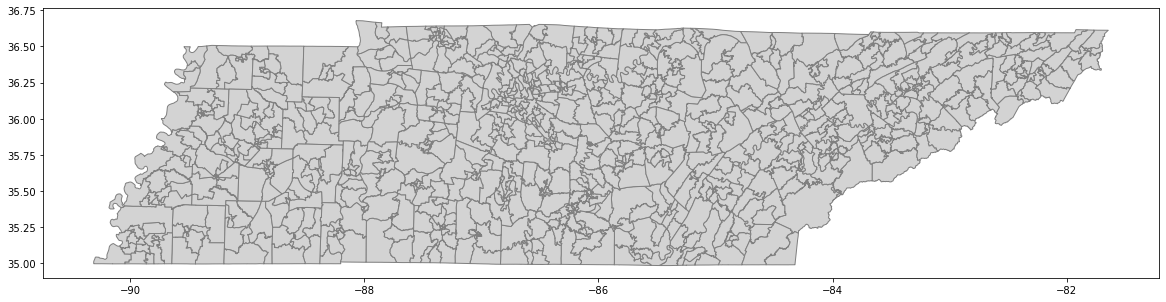

In [4]:
ax = tn_shape.plot(figsize = (20, 6), color = 'lightgrey', edgecolor = 'grey');

### 2/Need to get a geometry for tn_pop:

In [5]:
tn_pop = pd.read_csv('../data/tn_pop_clean.csv')
tn_pop.head()

,city,state,county_name,latitude,longitude,population,density,source,zips
0,Nashville,Tennessee,Davidson,36.1715,-86.7843,1081903.0,544.0,polygon,37027 37138 37076 37072 37205 37201 37206 3724...
1,Memphis,Tennessee,Shelby,35.1046,-89.9773,1066967.0,792.0,polygon,38120 38127 38107 38106 38105 38104 38103 3810...
2,Knoxville,Tennessee,Knox,35.9692,-83.9496,586048.0,733.0,polygon,37918 37912 37909 37902 37924 37920 37921 3792...
3,Chattanooga,Tennessee,Hamilton,35.0657,-85.2488,415501.0,493.0,polygon,37415 37416 37410 37411 37419 37409 37421 3736...
4,Clarksville,Tennessee,Montgomery,36.5695,-87.3420,188746.0,618.0,polygon,42223 37043 37042 37040 37044


In [6]:
tn_pop_geo = gpd.GeoDataFrame(tn_pop, geometry=gpd.points_from_xy(tn_pop.longitude, tn_pop.latitude))

tn_pop_geo.head(3)

,city,state,county_name,latitude,longitude,population,density,source,zips,geometry
0,Nashville,Tennessee,Davidson,36.1715,-86.7843,1081903.0,544.0,polygon,37027 37138 37076 37072 37205 37201 37206 3724...,POINT (-86.78430 36.17150)
1,Memphis,Tennessee,Shelby,35.1046,-89.9773,1066967.0,792.0,polygon,38120 38127 38107 38106 38105 38104 38103 3810...,POINT (-89.97730 35.10460)
2,Knoxville,Tennessee,Knox,35.9692,-83.9496,586048.0,733.0,polygon,37918 37912 37909 37902 37924 37920 37921 3792...,POINT (-83.94960 35.96920)


In [7]:
tn_shape.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
tn_pop_geo = gpd.GeoDataFrame(tn_pop_geo, 
                           crs = tn_shape.crs, 
                           geometry = tn_pop['geometry'])

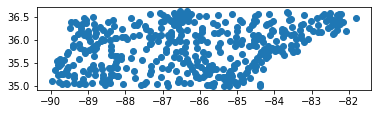

In [9]:
tn_pop_geo.plot();

### 3/Need to get a geometry for earthquake_tn:

In [10]:
earthquake_tn = pd.read_csv('../data/earthquake_tn_01_clean.csv')
earthquake_tn.head()

,date,latitude,longitude,depth,magnitude,news_source,latest_updated,place,seismic_type,location_error,depth_error,magnitude_error,review_status,year,month,day,time,state,city
0,2020-10-23 04:09:18.260,36.332833,-89.484667,4.93,1.65,nm,2020-10-23T16:52:09.410Z,"5 km SSW of Tiptonville, Tennessee",earthquake,0.33,0.27,0.068,reviewed,2020,10,23,04:09:18.260000,Tennessee,Tiptonville
1,2020-10-21 03:00:08.800,36.313667,-89.536167,9.50,1.23,nm,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,reviewed,2020,10,21,03:00:08.800000,Tennessee,Ridgely
2,2020-10-20 18:50:21.800,36.267500,-89.523333,8.84,2.33,nm,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,reviewed,2020,10,20,18:50:21.800000,Tennessee,Ridgely
3,2020-10-19 20:19:38.490,36.224000,-82.817167,17.27,2.31,se,2020-10-23T06:52:55.336Z,"6 km N of Greeneville, Tennessee",earthquake,0.91,1.69,0.099,reviewed,2020,10,19,20:19:38.490000,Tennessee,Greeneville
4,2020-10-19 05:15:25.090,36.209500,-89.476167,6.33,1.59,nm,2020-10-19T13:03:45.780Z,"6 km S of Ridgely, Tennessee",earthquake,0.26,0.56,0.086,reviewed,2020,10,19,05:15:25.090000,Tennessee,Ridgely


In [11]:
earthquake_tn_geo = gpd.GeoDataFrame(earthquake_tn, geometry=gpd.points_from_xy(earthquake_tn.longitude, earthquake_tn.latitude))
earthquake_tn_geo.head(3)

,date,latitude,longitude,depth,magnitude,news_source,latest_updated,place,seismic_type,location_error,depth_error,magnitude_error,review_status,year,month,day,time,state,city,geometry
0,2020-10-23 04:09:18.260,36.332833,-89.484667,4.93,1.65,nm,2020-10-23T16:52:09.410Z,"5 km SSW of Tiptonville, Tennessee",earthquake,0.33,0.27,0.068,reviewed,2020,10,23,04:09:18.260000,Tennessee,Tiptonville,POINT (-89.48467 36.33283)
1,2020-10-21 03:00:08.800,36.313667,-89.536167,9.50,1.23,nm,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,reviewed,2020,10,21,03:00:08.800000,Tennessee,Ridgely,POINT (-89.53617 36.31367)
2,2020-10-20 18:50:21.800,36.267500,-89.523333,8.84,2.33,nm,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,reviewed,2020,10,20,18:50:21.800000,Tennessee,Ridgely,POINT (-89.52333 36.26750)


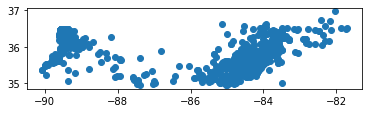

In [12]:
earthquake_tn_geo.plot();

In [13]:
earthquake_tn_geo = gpd.GeoDataFrame(earthquake_tn_geo, 
                           crs = tn_shape.crs, 
                           geometry = tn_pop['geometry'])

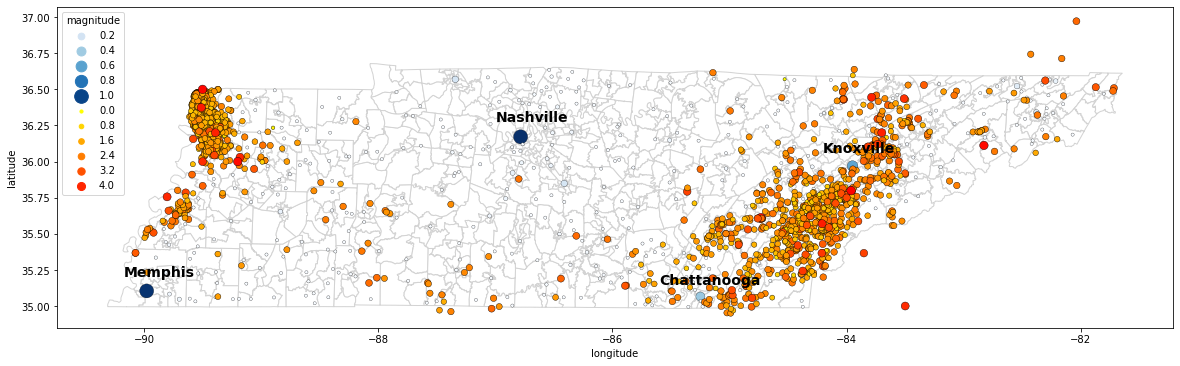

In [32]:
ax = tn_shape.plot(figsize = (20, 6), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=tn_pop_geo, x="longitude", y="latitude", hue="population", palette="Blues", size="population", sizes=(10, 200), edgecolor = 'black')

sns.scatterplot(data=earthquake_tn_geo, x="longitude", y="latitude", hue="magnitude",palette="autumn_r", size="magnitude", sizes=(10, 75), edgecolor = 'black')

plt.annotate(text = 'Nashville', xy = (-86.7843, 36.1715), fontsize = 14, fontweight = 'bold',
             xytext = (-86.999, 36.28))
plt.annotate(text = 'Memphis', xy = (-89.9773, 35.1046), fontsize = 14, fontweight = 'bold',
             xytext = (-90.1773, 35.2046))
plt.annotate(text = 'Knoxville', xy = (-83.9496, 35.9692), fontsize = 14, fontweight = 'bold',
             xytext = (-84.2, 36.065))
plt.annotate(text = 'Chattanooga', xy = (-85.2488, 35.0657), fontsize = 14, fontweight = 'bold',
             xytext = (-85.6, 35.15));

### 4/ What about the city density shape:

In [16]:
tn_city_shape = gpd.read_file('../data/TN_cities/tn_cities.shp')
tn_city_shape.head()

,AREA,PERIMETER,TNCTY83_,TNCTY83_ID,OWNED_BY,NAME,FIPS_55,STATE,COUNTY,PLACE,CENSUS_FIP,CENSUS,ORIG_NAME,geometry
0,0.005384,0.412769,0,0,0,COOKEVILLE,4714116920,47,141,16920,471410295,0295,Cookeville city,"POLYGON ((-85.46095 36.19027, -85.46130 36.184..."
1,0.019122,1.320603,2,612928513,0,CLARKSVILLE,4712515160,47,125,15160,471250250,0250,Clarksville city,"POLYGON ((-87.33969 36.59914, -87.33718 36.599..."
2,0.000117,0.041600,3,633900038,0,MITCHELLVILLE,4716549460,47,165,49460,471650960,0960,Mitchellville town,"POLYGON ((-86.54017 36.62787, -86.54490 36.626..."
3,0.000013,0.019241,4,0,0,None,None,None,None,None,None,None,None,"POLYGON ((-86.56570 36.63078, -86.56414 36.633..."
4,0.000098,0.047860,5,0,0,None,None,None,None,None,None,None,None,"POLYGON ((-86.56570 36.63078, -86.55852 36.627..."


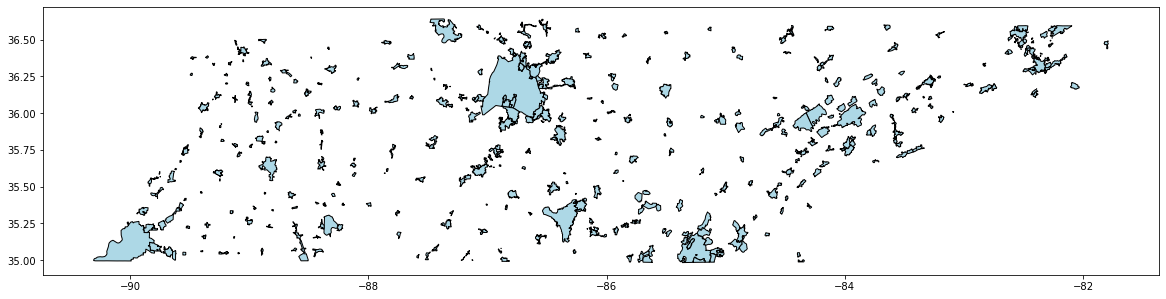

In [18]:
ax = tn_city_shape.plot(figsize = (20, 6), color = 'lightblue', edgecolor = 'black');

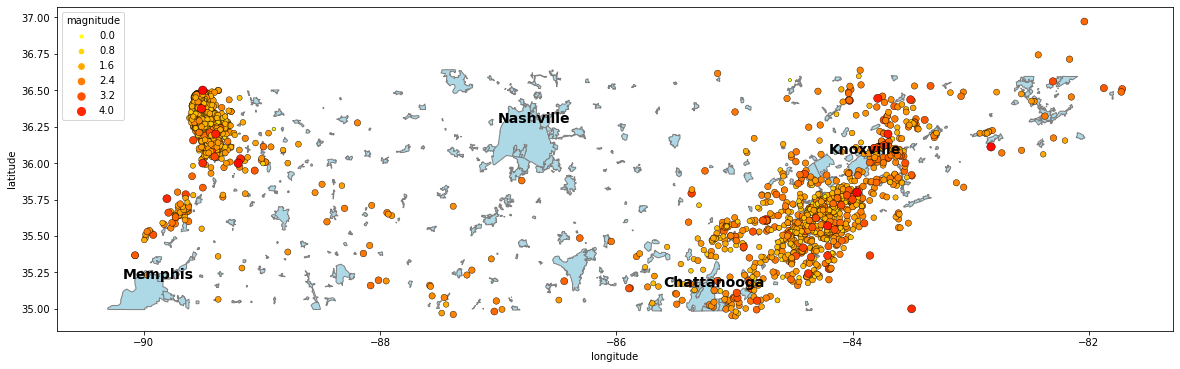

In [30]:
ax = tn_city_shape.plot(figsize = (20, 6), color = 'lightblue', edgecolor = 'grey')

#sns.scatterplot(data=tn_pop_geo, x="longitude", y="latitude", hue="population", palette="Blues", size="population", sizes=(10, 200), edgecolor = 'black')

sns.scatterplot(data=earthquake_tn_geo, x="longitude", y="latitude", hue="magnitude",palette="autumn_r", size="magnitude", sizes=(10, 75), edgecolor = 'black')

plt.annotate(text = 'Nashville', xy = (-86.7, 35.8), fontsize = 14, fontweight = 'bold',
             xytext = (-86.999, 36.28))
plt.annotate(text = 'Memphis', xy = (-89.4, 36.2), fontsize = 14, fontweight = 'bold',
             xytext = (-90.1773, 35.2046))
plt.annotate(text = 'Knoxville', xy = (-83.9496, 35.9692), fontsize = 14, fontweight = 'bold',
             xytext = (-84.2, 36.065))
plt.annotate(text = 'Chattanooga', xy = (-85.2488, 35.0657), fontsize = 14, fontweight = 'bold',
             xytext = (-85.6, 35.15));